# Data Preparation for Imbalanced Data: Credit Card Fraud Detection

**TL;DR** This notebook evaluates the performance of a simple Logistic Regression on the imbalanced Credit Card Fraud data from kaggle. The focus lies on the data preparation: **Autoencoder, Oversampling (SMOTE) and Random Undersampling** are used to transform the data before applying the model. Because it is a common mistake to apply data transformations (e.g. scaling) in a way that leads to data leakage, this topic will also be covered. **TODO:** Results

## Introduction

- **Context:** In order to enhance security, credit card companies would like to detect fraudulent transactions. Machine Learning can help with this.
- **Limitations:** It is relatively simple to increase the number of correctly classified fraudulent transactions at the cost of misclassifying normal transactions. Weighing the economic costs of misclassifying normal and fradulent transactions and therefore identifying the best result is beyond the scope of the analysis.

### Description of the Dataset
The dataset contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. (Source: [kaggle.com/mlg-ulb/creditcardfraud](https://www.kaggle.com/mlg-ulb/creditcardfraud))

### Approach

A Logistic Regression will be performed after applying different tequniches for dealing with imbalanced data to the data set. We considere a couple of options for dealing with the imbalance problem and settled for the following four:

1. Scale the data only: This will show the performance on the imbalanced data and serves as a baseline for further comparison.
2. Use an Autoencoder to extract a latent representation of the training data. Compression of the data might improve the inherent information.
3. Oversample the data: Oversampling will yield balanced classes but with a lot of data that makes training computationally expensive.
4. Undersample the data: Undersampling will yield balanced classes but with the cost of loss of information.

### Evaluation Metric

As proposed by the data set provider **Area Under the Precision-Recall Curve (AUPRC)** is used for performance evaluation. Confusion matrix accuracy is not meaningful for unbalanced classification. 

## Prerequisites

### Import packages

In [1]:
import json
import zipfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix,
                             plot_precision_recall_curve)
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     cross_val_score, train_test_split)
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential
from tqdm.keras import TqdmCallback

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

print(tf.__version__)

2.1.0


### Set Global Variables

In [2]:
seed = 1
tf.random.set_seed(42)
accuracy = 'average_precision' # equals to area under recall precision curve
lr_max_iterations = 10000 # increased max_iter to allow lbfgs-solver converging

## Data Preparation

### Import Data
The dataset exceeds githubs allowd file-size limits and is therefore only available in .zip format. The helper-function *load_data()* allows data loading independent from whether the archive is already unpacked or not.

In [ ]:
def load_data():
    """ Unzip archive if necessary, import the data and return a Dataframe """
    
    data_dir = Path.cwd() / 'data'  
    csv_file = Path(data_dir/'creditcard.csv')
    zip_file = Path(data_dir/'creditcard.zip')
    
    if not csv_file.exists() and zip_file.exists():
        with zipfile.ZipFile(zip_file,"r") as zip_ref:
            zip_ref.extractall(data_dir)        
        
    return pd.read_csv(csv_file)

In [4]:
df = load_data()
# let's make sure the data is loaded as expected
assert(df.shape[0] == 284807)
assert(df.shape[1] == 31)

### Split into Train and Test Set
For splitting we use sklearns *train_test_split* with the stratify option in order to keep the ratio of normal and fraudulent transactions in the test and training data equal.

In [5]:
X_orig = df.drop('Class', axis=1)
y_orig = df.Class

X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=0.2,
                                                    random_state=seed, stratify=y_orig)
test_data = [X_test, y_test]

In [ ]:
print(f"Training data class counts:\n {y_test.value_counts()}")
print('')
print(f"Test data class counts:\n {y_test.value_counts()}")
print('')
print(f"Test-Train-Ratio: {y_test.shape[0]/y_orig.shape[0]:.2f}")

### Scaling the data while avoiding Data Leakage
Yes, you saw right, we did not scale the data before the split. In order to avoid information from the training data [leaking](https://machinelearningmastery.com/data-leakage-machine-learning/) into the test set we will do this later. I see people far too often scaling their whole dataset before the model training. This may improve your models performance in an unwanted manner and should be avoided. Instead one should do it like this:
 - Create the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) object
 - Fit scaler on the training data and transform it
 - Transform the test data without fitting the scaler again

In [8]:
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

test_data_scaled = [X_test_scaled, y_test]

Since we will be using cross validation in this notebook, we also have to make sure that we are scaling the date after creating the folds, such that the validation set does not know about the distribution in the training set either. Luckily sklearns [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) helps us with that: it will fit the scaler only on the training folds.

## Train and Evaluate a Simple Model
Let's create a simple Logistic Regression model to see how things go. We will not compare multiple models but rather focus on dealing with the imbalance in this dataset. To estimate the models performance we use [average precision score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) because it equals the Area Under the Precision-Recall Curve.

In [9]:
def evaluate_model(test_data, estimator, name='Not specified'):
    
    X_test = test_data[0]
    y_test = test_data[1]
    
    num_fraud_cases_in_test = len(y_test[y_test==1])
    num_normal_cases_in_test = len(y_test[y_test==0])
    
    predictions = estimator.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    
    # Plot normalized confusion matrix and precision recall curve
    fig, axes = plt.subplots(1,2, figsize=(14,6))
    
    plot_confusion_matrix(estimator, X_test, y_test, normalize='true',
                          display_labels=['Normal', 'Fraud'], cmap='Greens', values_format=".4f", ax=axes[0])
    axes[0].set_title('Confusion Matrix (normalized)')
    
    prc = plot_precision_recall_curve(estimator, X_test, y_test, name=name, ax=axes[1])
    axes[1].set_title('Precision Recall Curve')
    plt.tight_layout()
    
    # Print summary    
    print(f"Classified \t{cm[1,1]} out of {num_fraud_cases_in_test} \tfraud cases correctly")
    print(f"Misclassified \t{cm[0,1]} out of {num_normal_cases_in_test} normal cases")
    print(f"Average preicision score is {prc.average_precision:.4f}")

Classified 	69 out of 98 	fraud cases correctly
Misclassified 	10 out of 56864 normal cases
Average preicision score is 0.8136


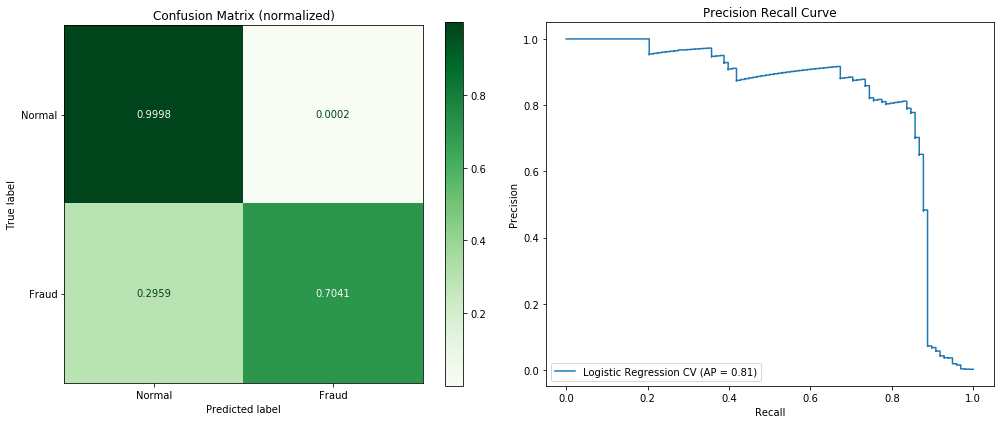

In [67]:
simple_LR = LogisticRegression(max_iter=lr_max_iterations, random_state=seed) 
simple_LR.fit(X_train_scaled, y_train)
evaluate_model([X_test_scaled, y_test], simple_LR, name='Logistic Regression CV')

The baseline model doesn't perform too bad. It already identifies 70% of frauds and classifies 99,98% of normal transactions correctly. The area under the precision-recall-cruve or average precision is 0.81.

## Autoencoder + Logistic Regression
Here we are using the Autoencoder for dimensionality reduction rather then anomaly detection
 - Should we compare it with PCA or t-sne?
 - How does classification via reconstruction error work?

What is a good number of (normal) examples for the Autoencoder training?
 - How many examples do we need to train the logistic regression?
 - Because AE is a neural network, probably the more examples the better

### Prepare Data for Autoencoder

In [13]:
# separate normal and fraudulent transactions
X_train_norm = X_train[y_train == 0]
print(f"Training data has {X_train_norm.shape[0]} normal transactions")

# Take a fraction of that for training the Autoencoder
X_train_AE = X_train_norm.sample(frac=0.5, random_state=seed)
X_train_AE_scaled = StandardScaler().fit_transform(X_train_AE)

Training data has 227451 normal transactions


### Create and Train Autoencoder Model

In [49]:
load_model = True 
num_epochs = 500
model_dir = f'models/autoencoder_{num_epochs}'
print(f"Saved model in {model_dir}")

Saved model in models/autoencoder_500


In [50]:
# load model
if load_model:
    model = tf.keras.models.load_model(model_dir)
    with open(model_dir + '/trainHistoryDict.json', 'r') as f:
        history = json.load(f)
    model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 100)               3100      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                3030      
Total params: 16,280
Trainable params: 16,280
Non-trainable params: 0
_________________________________________________________________


When training the Autoencoder do we need a validation data?

In [51]:
def create_model(input_dim=30, latent_dim=50):
    """ Creates an Autoencoder Model where input_dim is the number of features.
    The encoding part uses L1-regularization as sparsity constraint """
    
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(100, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
    latent =  Dense(latent_dim, activation='relu')(encoded)
    decoded = Dense(100, activation='relu')(latent)
    output_layer = Dense(input_dim, activation='linear')(decoded)
    
    return Model(input_layer, output_layer)

In [52]:
# when using a saved model there is no need for model creation and training
if not load_model:
    model = create_model()
    model.compile(optimizer="adadelta", loss="mse")
    model.summary()
    
    # firt autoencoder
    history = model.fit(X_train_AE_scaled, X_train_AE_scaled,
                        batch_size=64, epochs=num_epochs, verbose=0, validation_split=0.05,
                        callbacks=[TqdmCallback(), EarlyStopping(patience=3)])
    
    # save model
    !mkdir "$model_dir/variables"
    model.save(model_dir)

    # save history
    history = history.history
    with open(model_dir + 'trainHistoryDict.json', 'w') as f:
        json.dump(history, f)

Plot the training history

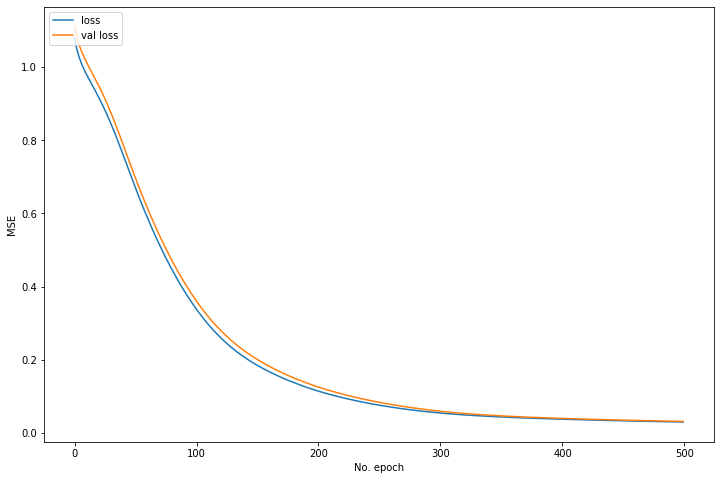

In [53]:
plt.figure(figsize=(12,8))
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val loss')
plt.ylabel('MSE')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

### Create Encoder Model

In [54]:
encoder = Sequential([model.layers[0],
                      model.layers[1],
                      model.layers[2]])
encoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               3100      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
Total params: 8,150
Trainable params: 8,150
Non-trainable params: 0
_________________________________________________________________


### Extract Latent Representation

In [55]:
# Remove AE samples from training data for classifier
X_train_clf = X_train.drop(X_train_AE.index)
y_train_clf = y_train.drop(X_train_AE.index)

# maybe scaling here can be done with the first scaler object
latent_scaler = StandardScaler()
X_train_clf_scaled = latent_scaler.fit_transform(X_train_clf)
X_test_clf_scaled = latent_scaler.transform(X_test)

In [56]:
# Extract latent representation
X_train_latent = encoder.predict(X_train_clf_scaled)
X_test_latent = encoder.predict(X_test_scaled)

In [57]:
latent_scaler = StandardScaler()
X_train_latent_scaled = latent_scaler.fit_transform(X_train_latent)
X_test_latent_scaled = latent_scaler.transform(X_test_latent)

### Logistic Regression CV with latent data

Classified 	77 out of 98 	fraud cases correctly
Misclassified 	16 out of 56864 normal cases
Average preicision score is 0.8265


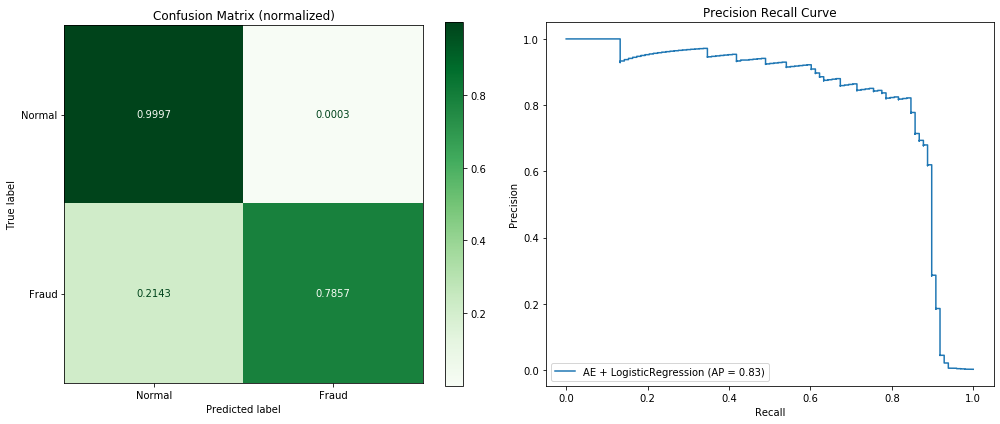

In [58]:
lrcv = LogisticRegressionCV(Cs=5, scoring=accuracy, max_iter=lr_max_iterations, n_jobs=-1, random_state=seed)
lrcv.fit(X_train_latent_scaled, y_train_clf)
evaluate_model([X_test_latent_scaled, y_test], lrcv, name='AE + LogisticRegression')

## Oversampling + Logistic Regression

In [59]:
oversampling = SMOTE(sampling_strategy='minority', n_jobs=-1, random_state=seed)
# log_reg = LogisticRegression(max_iter=lr_max_iterations, random_state=seed)
log_reg = LogisticRegressionCV(Cs=5, scoring=accuracy, max_iter=lr_max_iterations, n_jobs=-1, random_state=seed)

In [60]:
model = Pipeline([
        ('sampler', oversampling),
        ('transformer', StandardScaler()),
        ('classification', log_reg)])
model.fit(X_train, y_train);

Classified 	90 out of 98 	fraud cases correctly
Misclassified 	533 out of 56864 normal cases
Average preicision score is 0.8046


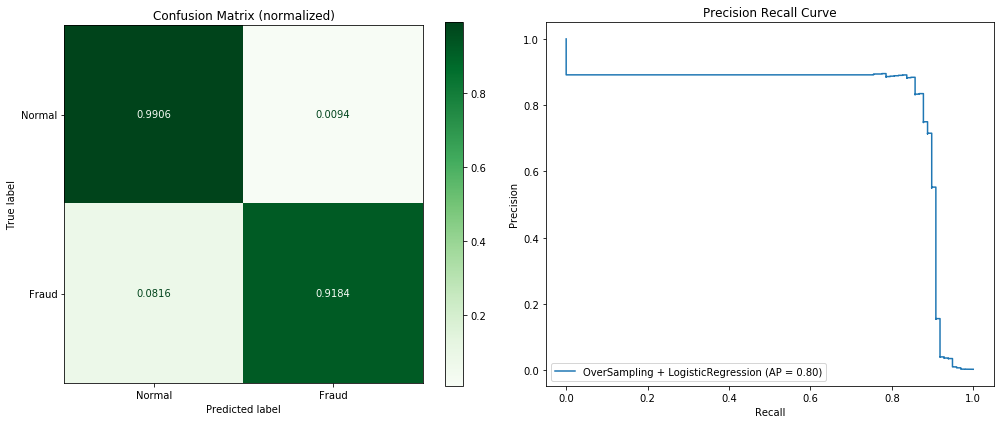

In [61]:
evaluate_model(test_data, model, name='OverSampling + LogisticRegression')

## Undersampling + Logistic Regression

Best parameter (CV score=0.725):
{'classification__C': 10000.0}
Classified 	90 out of 98 	fraud cases correctly
Misclassified 	2067 out of 56864 normal cases
Average preicision score is 0.7205


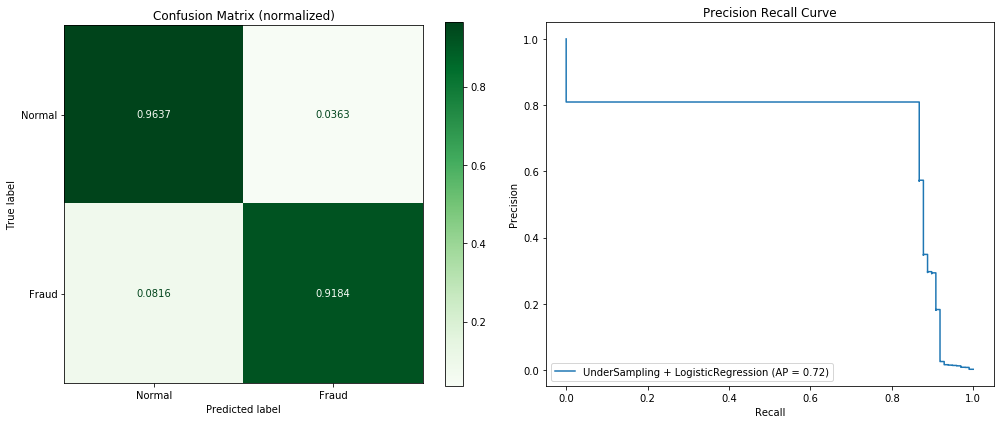

In [62]:
rus = RandomUnderSampler(sampling_strategy='majority', random_state=seed)
logistic = LogisticRegression(max_iter=lr_max_iterations, random_state=seed)

param_grid = {
    'classification__C': np.logspace(-4, 4, 5)
}

pipe = Pipeline([
        ('sampling', rus),
        ('transformer', StandardScaler()),
        ('classification', logistic)])

search = GridSearchCV(pipe, param_grid, scoring=accuracy, n_jobs=-1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

evaluate_model(test_data, search, 'UnderSampling + LogisticRegression')

In [63]:
rus = RandomUnderSampler(sampling_strategy='majority', random_state=seed)
log_reg = LogisticRegressionCV(Cs=5, scoring=accuracy, max_iter=lr_max_iterations, n_jobs=-1, random_state=seed)

In [64]:
model = Pipeline([
        ('sampling', rus),
        ('transformer', StandardScaler()),
        ('classification', log_reg)])
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('sampling',
                 RandomUnderSampler(random_state=1, replacement=False,
                                    sampling_strategy='majority')),
                ('transformer',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classification',
                 LogisticRegressionCV(Cs=5, class_weight=None, cv=None,
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1.0, l1_ratios=None,
                                      max_iter=10000, multi_class='auto',
                                      n_jobs=-1, penalty='l2', random_state=1,
                                      refit=True, scoring='average_precision',
                                      solver='lbfgs', tol=0.0001, verbose=0))],
         verbose=False)

Classified 	91 out of 98 	fraud cases correctly
Misclassified 	1389 out of 56864 normal cases
Average preicision score is 0.6490


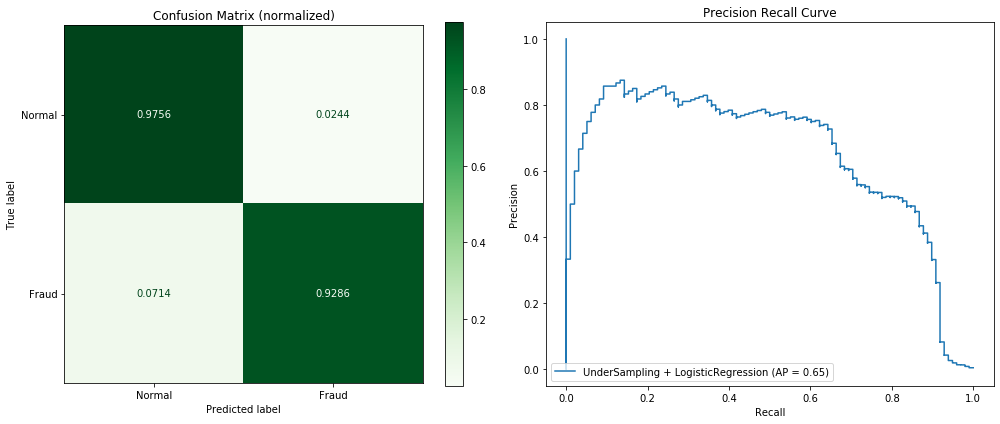

In [65]:
evaluate_model(test_data, model, 'UnderSampling + LogisticRegression')

## TODO Conclusion

For a PR curve, a good classifer aims for the upper right corner of the chart but upper left for the ROC curve.

While PR and ROC curves use the same data, i.e. the real class labels and predicted probability for the class lables, you can see that the two charts tell very different stories, with some weights seem to perform better in ROC than in the PR curve.

While the blue, w=1, line performed poorly in both charts, the black, w=10000, line performed "well" in the ROC but poorly in the PR curve. This is due to the high class imbalance in our data. ROC curve is not a good visual illustration for highly imbalanced data, because the False Positive Rate ( False Positives / Total Real Negatives ) does not drop drastically when the Total Real Negatives is huge.

Whereas Precision ( True Positives / (True Positives + False Positives) ) is highly sensitive to False Positives and is not impacted by a large total real negative denominator.

The biggest difference among the models are at around 0.8 recall rate. Seems like a lower weight, i.e. 5 and 10, out performs other weights significantly at 0.8 recall. This means that with those specific weights, our model can detect frauds fairly well (catching 80% of fraud) while not annoying a bunch of customers with false positives with an equally high precision of 80%.

Without further tuning our model, and of course we should do cross validation for any real model tuning/validation, it seems like a vanilla Logistic Regression is stuck at around 0.8 Precision and Recall.

So how do we know if we should sacrifice our precision for more recall, i.e. catching fraud? That is where data science meets your core business parameters. If the cost of missing a fraud highly outweighs the cost of canceling a bunch of legit customer transactions, i.e. false positives, then perhaps we can choose a weight that gives us a higher recall rate. Or maybe catching 80% of fraud is good enough for your business if you can minimize also minimize the "user friction" or credit card disruptions by keeping our precision high.
[ref](https://www.kaggle.com/lct14558/imbalanced-data-why-you-should-not-use-roc-curve)

## TODO Visualize Latent Data

In [66]:
from sklearn.manifold import TSNE
# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html?highlight=tsne#sklearn.manifold.TSNE

def plot_tsne(X, y, title=None):
        
    tsne = TSNE(n_components=2, method='exact', n_jobs=-1, random_state=seed).fit_transform(X_sample)
    
    fig = plt.figure(figsize=(12, 12))
    plt.scatter(tsne[:, 0], tsne[:, 1], cmap='coolwarm', c=(y==0), label='Normal', linewidth=2)
    plt.scatter(tsne[:, 0], tsne[:, 1], cmap='coolwarm', c=(y==1), label='Fraud', linewidth=2)
    plt.title(title, fontsize=14)
    plt.show()
    
""" TODO """

# Separate fraudulent and normal transactions
X_fraud = X_train_latent[y_train_clf == 1]
y_Fraud = y_train_clf[y_train_clf == 1]

X_normal = X_train_latent[y_train_clf == 0]
y_normal = y_train_clf[y_train_clf == 0]
print(X_normal.shape)
# Sample some normal cases to speed up tsne
X_normal_sub = np.random.choice(X_normal, 2000)
y_normal_sub = y_normal(X_normal_sub.index)

X_sub = np.concatenate([X_fraud, X_normal_sub])
y_sub = np.concatenate([y_fraud, y_normal_sub])

(113725, 50)


ValueError: a must be 1-dimensional